In [2]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import itertools

import torch
from torch import nn

import youtokentome as yttm

from utils.base import get_params_number, init_random_seed, train_loop_GAN
from utils.poetry import *
from utils.transformer_tools import *

init_random_seed(1702)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
horus = load_chunks("./datasets/DarkTower/DT14_red.txt", chunk_size=300)

ALL_LEN = len(horus)
print(ALL_LEN)
len_for_steps = int(ALL_LEN / 3)
horus_for_GAN = horus[len_for_steps * 2:]
horus = horus[:len_for_steps * 2]
print(len(horus))
print(len(horus_for_GAN))

22507
15004
7503


In [4]:
for_mauve_test = horus_for_GAN[len(horus_for_GAN)-100:]
horus_for_GAN = horus_for_GAN[:len(horus_for_GAN)-100]

print(len(horus_for_GAN))
print(len(for_mauve_test))

7403
100


In [5]:
BPE_MODEL_FILENAME = './models/tokens/dt_bpe_2000.yttm'

tokenizer = yttm.BPE(BPE_MODEL_FILENAME)
print(' '.join(tokenizer.vocab()))

<PAD> <UNK> <BOS> <EOS> ▁ e t a o n h i s d r l u w g c m f y . b , p k v T I E H “ ’ ” A S - " R O ? ' N W B D J Y M C L x z ! j G F … ; U P q : K ) ( V ­ — 1 – 2 3 4 9 5 7 0 Q 6 8 X Z / ‘ $ * » ^ \ # + « ~ _ ] [ & ▁t he ▁a in ▁s ▁the ▁w ▁o ▁h nd ed ▁b er ou ing re ▁f it ▁c at is ▁d ▁l ▁m as en ▁th ▁and ▁to ▁of ▁he ll an ▁g ar ad es on or ▁p ▁in ▁n ▁T ▁was id ow ▁be om ut ▁it gh ld ▁y ot ▁on le ke ▁e ▁“ ac ▁his ▁I im ly ▁st ▁H us and ic ▁r ▁had ▁you oo un ▁The ght ie et ay ▁that ▁wh ve dd al ▁S ver ▁sa os ▁as ▁E ir ol ▁re ▁He ith ▁A ould ▁at ’s ain ight ▁with ▁R ur ent ked ddie ▁Eddie el ▁him e. her ▁k ake am ▁sh ▁for ▁B ▁u ▁J ▁li ▁but e, ▁an ter all ack ▁" ▁said ▁ha ▁se ▁her oland ▁not ▁Roland ling s. pp ill ch ▁fr st ▁loo ▁do if ion s, ▁gun ▁W ▁Jake ard .” ▁kn ▁M ome ore ▁up ’t ▁like ▁she ust il ed. ▁whe ere ▁O ▁C ound ▁al th ▁out ell ▁guns ▁j ▁tr ant ▁from ind ▁all ro ▁one ck ▁were linger ▁this ▁they ▁gunslinger um em ▁been ▁them ▁would ▁have ▁ne ▁bl ▁le ▁ag to ap ?” hed ▁D ▁su ood

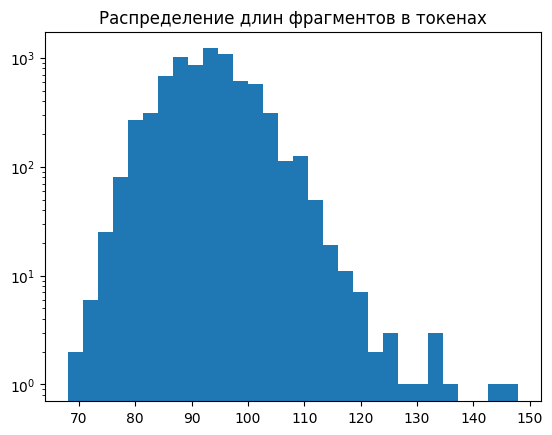

In [6]:
token_ids = tokenizer.encode(horus_for_GAN, bos=True, eos=True)

plt.hist([len(sent) for sent in token_ids], bins=30)
plt.title('Распределение длин фрагментов в токенах')
plt.yscale('log')

In [7]:
start_length = 20
end_length = 70

all_dataset = Dataset_for_GAN(token_ids, start_len=start_length, end_len=end_length)

In [8]:
check = all_dataset[2036]

print(check[0])
print(check[1])
print(tokenizer.decode(check[0].tolist()))
print(tokenizer.decode(check[1].tolist()))

[ 152   25  426  188  171  371  668  163 1101  251  530 1101  366  127
  233  406 1468 1238  136 1224]
[ 112  105  450  110   13 1330  198  253    8  137 1421 1089  105 1010
  538  137 1268  638  785  384  104  287 1127  489 1324 1779  127  324
  513  210  326  561  147  110  140  105  683  125  114  311 1303  155
    6  576  162  129  105 1585  258  102  355  124  327  373  132  177
   23  668  484 1786  188  797  188  507  370  170  843  776  539  143]
['y, just as you said. Only wait.” They waited, and not twenty minutes lat']
['er the Peddler’s Moon rose above the horizon-a perfect summer moon, huge and orange. It loomed in the darkening violet swim of the sky like a crashing planet. On its face, as clear as anyone had ever seen it, was']


In [9]:
D_model = LSTM_Discriminator(100, 256, tokenizer.vocab_size())
print('Количество параметров дискриминатора', get_params_number(D_model))

G_model = Language_Model(
    vocab_size = tokenizer.vocab_size(),
    embedding_size = 512,
    backbone = Transformer_Encoder(
        nn.TransformerEncoderLayer(
            d_model = 512,
            nhead = 16,
            dim_feedforward = 1024,
            dropout = 0.3
        ),
        num_layers=5
    ),
    emb_dropout = 0.2
)
print('Количество параметров генератора', get_params_number(G_model))

Количество параметров дискриминатора 655301
Количество параметров генератора 12563920


In [10]:
optimizer_SD_G = torch.load('./models/Lord/DT/2/Lord_opt.pth')
G_model.load_state_dict(torch.load('./models/Lord/DT/2/Lord.pth'))

<All keys matched successfully>

In [11]:
batch_size = 64

model_D, model_G, optimizer_D, optimizer_G, loss_history_D, loss_history_G = train_loop_GAN(
    D_model,
    G_model,
    all_dataset,
    lm_b_cross_entropy,
    lr_D=1e-2,
    lr_G=1e-2,
    epoch_n=150,
    batch_size=batch_size,
    device='cuda',
    # early_optimizer_SD_D=optimizer_SD_D,
    early_optimizer_SD_G=optimizer_SD_G,
    tokenizer=tokenizer,
    need_to_gen=True,
    end_chunk=end_length,
    phrase="Today we are going"
)

Эпоха 0


116it [02:11,  1.14s/it]


Эпоха прошла за 131.87 секунд
Средняя функция потерь для дискриминатора = 0.23575851374209442
Средняя функция потерь для генератора = 5.042009062808136
Today we are going from Topeka, and Mans-World.” “YES.” “I SEEEAH YOUR QUICK YOU ME RIDDLES, ROLAND OF
Следующая эпоха
Эпоха 1


116it [02:11,  1.13s/it]


Эпоха прошла за 131.51 секунд
Средняя функция потерь для дискриминатора = 0.06224592505143313
Средняя функция потерь для генератора = 7.199996076781174
Today we are going to die on the Boing Mid-World Railway. Lended to the Burt Bridge Tom Dravel Huns), Bridor
Следующая эпоха
Эпоха 2


116it [02:11,  1.14s/it]


Эпоха прошла за 131.93 секунд
Средняя функция потерь для дискриминатора = 0.047703826603286995
Средняя функция потерь для генератора = 7.757681747962689
Today we are going?" "Fuckiah. "Firractin," the gunslinger said in a voice: "If it's not, I mean, I mean, you can't do it?" "B
Следующая эпоха
Эпоха 3


116it [02:11,  1.14s/it]


Эпоха прошла за 131.73 секунд
Средняя функция потерь для дискриминатора = 0.019368246015550664
Средняя функция потерь для генератора = 9.313554804900598
Today we are going for the Prisoner, and the Path of the Wonder-Haxis and Pubes and Grays area Shakes of Monkid-World-and-w
Следующая эпоха
Эпоха 4


116it [02:11,  1.14s/it]


Эпоха прошла за 131.77 секунд
Средняя функция потерь для дискриминатора = 0.019887344316822268
Средняя функция потерь для генератора = 9.787839141385309
Today we are going over here,” he said, “anding a little closer.” “Ifor you are, you?” “I’m sorry,” Roland said in a low voice. “I don’t know,” Eddie said. “I
Следующая эпоха
Эпоха 5


116it [02:11,  1.14s/it]


Эпоха прошла за 131.77 секунд
Средняя функция потерь для дискриминатора = 0.017289569963207307
Средняя функция потерь для генератора = 9.38377674694719
Today we are going?” “I don’t know,” the boy said, and smiled a little. “Isn’t that much.” “All right.” “I’ll have to kill usual truth. I was a minute, but I think
Следующая эпоха
Эпоха 6


116it [02:11,  1.14s/it]


Эпоха прошла за 131.72 секунд
Средняя функция потерь для дискриминатора = 0.013624444929080019
Средняя функция потерь для генератора = 9.880779973391828
Today we are going to ask.” “Irange KA-TET MORE IS NOSTING MINUTH AS A RIDDLE, BUNST ARE NOT
Следующая эпоха
Эпоха 7


116it [02:11,  1.13s/it]


Эпоха прошла за 131.64 секунд
Средняя функция потерь для дискриминатора = 0.02222366326745471
Средняя функция потерь для генератора = 9.799131023472754
Today we are going?” “Are you sure?” The voice of Little Blaine asked. “YES. I WAST IT WELL RIDDLES, ROLUDLE OF NEW Y
Следующая эпоха
Эпоха 8


116it [02:12,  1.14s/it]


Эпоха прошла за 132.02 секунд
Средняя функция потерь для дискриминатора = 0.01943358995877447
Средняя функция потерь для генератора = 9.59642506467885
Today we are going to sleep. I think you know that?” “Didn’t I mean?” “Yes.” He looked at the gunslinger, and then shook his head.“I don’t know where I think you know that.” He
Следующая эпоха
Эпоха 9


116it [02:11,  1.14s/it]


Эпоха прошла за 131.81 секунд
Средняя функция потерь для дискриминатора = 0.02095323984821303
Средняя функция потерь для генератора = 10.053578310999377
Today we are going on ourselves?” “I CANNAKE YOU DE YOUR RIDDLESK?” Blaine asked. “THAT IS NOTHER, I WAS ROLAND
Следующая эпоха
Эпоха 10


116it [02:12,  1.14s/it]


Эпоха прошла за 132.21 секунд
Средняя функция потерь для дискриминатора = 0.013327189502135673
Средняя функция потерь для генератора = 9.98219578841637
Today we are going to drawn apolog. The Piper Bill, the Turtle of the Turtle, Transase, the Turtle. The Gray
Следующая эпоха
Эпоха 11


116it [02:10,  1.13s/it]


Эпоха прошла за 130.78 секунд
Средняя функция потерь для дискриминатора = 0.012295309967408559
Средняя функция потерь для генератора = 11.005228371455752
Today we are going?” “Answer Budically, I guesawed by the last of myth. I will.” “Exforry?” The gunslinger shook his head.“It
Следующая эпоха
Эпоха 12


116it [02:10,  1.13s/it]


Эпоха прошла за 130.87 секунд
Средняя функция потерь для дискриминатора = 0.009835671052785292
Средняя функция потерь для генератора = 10.692943046832907
Today we are going to happen if we were still cosoms of riddles.” “THAT IS NOT IS NOT TRURTIVE RIDDLES?” “Yes,” Roland said.
Следующая эпоха
Эпоха 13


116it [02:11,  1.13s/it]


Эпоха прошла за 131.03 секунд
Средняя функция потерь для дискриминатора = 0.020879454639035774
Средняя функция потерь для генератора = 10.696601999217066
Today we are going?” Eddie asked. “NOONE MUST CROBLEARE, ROLAND OF GILEAD. I WILL COME TOPEKA
Следующая эпоха
Эпоха 14


116it [02:11,  1.13s/it]


Эпоха прошла за 131.42 секунд
Средняя функция потерь для дискриминатора = 0.020986242006419444
Средняя функция потерь для генератора = 9.02040932096284
Today we are going?” “Yeah,” Roland said, and his voice sounded as he living in his voice as well: “THEE YOU TRABE MAKE YOU SAKE OF NE
Следующая эпоха
Эпоха 15


116it [02:11,  1.13s/it]


Эпоха прошла за 131.0 секунд
Средняя функция потерь для дискриминатора = 0.023706260532670623
Средняя функция потерь для генератора = 8.977860853589814
Today we are going?” Susannah’s voice cried. “THAT IS SUCHANNAHER OF YOUR RIDDLES TRY RIDDLES OF GILES
Следующая эпоха
Эпоха 16


116it [02:14,  1.16s/it]


Эпоха прошла за 134.71 секунд
Средняя функция потерь для дискриминатора = 0.0105001377382121
Средняя функция потерь для генератора = 10.509269549928863
Today we are going?” The gunslinger shook his head.“I don’t know.” The gunslinger shook his head. “Dread?” “Yes. Maybe I know.” “How could,” the man in black repliesta said nothing.
Следующая эпоха
Эпоха 17


116it [02:14,  1.16s/it]


Эпоха прошла за 134.19 секунд
Средняя функция потерь для дискриминатора = 0.014233587228804466
Средняя функция потерь для генератора = 10.482451381354496
Today we are going from where we going. 19 EDDIE 14 14 14 TAKE 19 14 1 1 2 23 23 23 23 28 1 2
Следующая эпоха
Эпоха 18


116it [02:10,  1.13s/it]


Эпоха прошла за 130.62 секунд
Средняя функция потерь для дискриминатора = 0.014139988906741752
Средняя функция потерь для генератора = 10.338932448420032
Today we are going out of the Beeka, and the Turies in the Grays are the Guardian Post of Mid-World Park-World Railway Centr
Следующая эпоха
Эпоха 19


116it [02:10,  1.13s/it]


Эпоха прошла за 130.61 секунд
Средняя функция потерь для дискриминатора = 0.011840978277930469
Средняя функция потерь для генератора = 10.241614695253043
Today we are going down there.” “Do you remember that?” Susannah asked. “YES IT’are, you mean,” Eddie said. “I’m sorry.” Roland nodded.“It has a lot, too. But I
Следующая эпоха
Эпоха 20


116it [02:10,  1.13s/it]


Эпоха прошла за 130.87 секунд
Средняя функция потерь для дискриминатора = 0.01380562801330535
Средняя функция потерь для генератора = 11.22304890895712
Today we are going in the Barieselow the Grays and the Burt Coadema Hospits of the Western Mid-World Railway C
Следующая эпоха
Эпоха 21


116it [02:10,  1.13s/it]


Эпоха прошла за 130.79 секунд
Средняя функция потерь для дискриминатора = 0.01434511562136573
Средняя функция потерь для генератора = 10.931311681352813
Today we are going?” “DOYOUNDST YOU ME OF NEW YOREVENT, JAKE OF NEW YORK. AW YORK. N
Следующая эпоха
Эпоха 22


116it [02:10,  1.13s/it]


Эпоха прошла за 130.67 секунд
Средняя функция потерь для дискриминатора = 0.009588368390190038
Средняя функция потерь для генератора = 12.003518745816987
Today we are going?” “THE OF NEWAHE,” Blaine said. “I HAVE SOULD EDDDIE OF NEW YORK.” Roland nodded.“I
Следующая эпоха
Эпоха 23


116it [02:10,  1.13s/it]


Эпоха прошла за 130.69 секунд
Средняя функция потерь для дискриминатора = 0.006176888795693983
Средняя функция потерь для генератора = 12.911366076304995
Today we are going?” Susannah asked. Roland shook his head.“What’s a little time,” Roland said. “Tell look of your story,” Eddie said. “Thankee-sai, Blaine,” Jake said.
Следующая эпоха
Эпоха 24


116it [02:10,  1.13s/it]


Эпоха прошла за 130.84 секунд
Средняя функция потерь для дискриминатора = 0.007257849869911924
Средняя функция потерь для генератора = 12.711934689817758
Today we are going to find out here?” Engineer Bob asked Engineer Bob. “Why do you want to take me to the bottom?” “I don’t know about Charlie,” said Charlie
Следующая эпоха
Эпоха 25


116it [02:10,  1.13s/it]


Эпоха прошла за 130.66 секунд
Средняя функция потерь для дискриминатора = 0.008902394093795386
Средняя функция потерь для генератора = 13.084352781032694
Today we are goingue of the Truths?” “Yeah.” “Jesus,” Eddie said. “I don’t know what you know.” “Is it not?” “Yes.” He sounded a little, but he didn’t
Следующая эпоха
Эпоха 26


116it [02:10,  1.13s/it]


Эпоха прошла за 130.59 секунд
Средняя функция потерь для дискриминатора = 0.00917518629880917
Средняя функция потерь для генератора = 12.736575167754602
Today we are going banked on?” Eddie asked. He was looking at Susannah. “All right?” “Yes. IVERE HAVE IF YOU SPEEXPERST.” “T
Следующая эпоха
Эпоха 27


116it [02:10,  1.13s/it]


Эпоха прошла за 130.62 секунд
Средняя функция потерь для дискриминатора = 0.012769332289751438
Средняя функция потерь для генератора = 13.103305430247866
Today we are going?" Unounces late. "Because of them," Eddie said in a low voice. "No," Eddie said. "Can. Let's goddam surely?" "T
Следующая эпоха
Эпоха 28


116it [02:10,  1.13s/it]


Эпоха прошла за 130.79 секунд
Средняя функция потерь для дискриминатора = 0.01407097611020398
Средняя функция потерь для генератора = 12.467317087896939
Today we are going?” “DO YOU ARE PROP IT WASTING FOR THREME,” Blaine invited. “SUS NOTHER THAT IS NOPTER
Следующая эпоха
Эпоха 29


116it [02:11,  1.13s/it]


Эпоха прошла за 131.11 секунд
Средняя функция потерь для дискриминатора = 0.00942916870422025
Средняя функция потерь для генератора = 12.66295550609457
Today we are going to phosphotographs on the beach. I don't know how they are, but they are the same. Drawing of the Thors and the
Следующая эпоха
Эпоха 30


116it [02:10,  1.13s/it]


Эпоха прошла за 130.94 секунд
Средняя функция потерь для дискриминатора = 0.014963792293577893
Средняя функция потерь для генератора = 12.220112915696768
Today we are going?” “I don’t know,” the man in black said. “I’m going to be.” He looked at the gunslinger, then looked at the man in black. “Is are you going to have to be.”
Следующая эпоха
Эпоха 31


116it [02:10,  1.13s/it]


Эпоха прошла за 130.89 секунд
Средняя функция потерь для дискриминатора = 0.012953651199621101
Средняя функция потерь для генератора = 12.235488464092386
Today we are going?” Blaine asked. “Thanks,” Eddie said. “ARECHE IS NE MORE, ROLAND OF NEW YORK.” “To I HEVED,
Следующая эпоха
Эпоха 32


116it [02:10,  1.13s/it]


Эпоха прошла за 130.69 секунд
Средняя функция потерь для дискриминатора = 0.015699264494067958
Средняя функция потерь для генератора = 12.051546220121713
Today we are going on our Fair-Day?” “If course it is, Blaine,” Jake said. “I don’t know. I think it isn’t it possible.” Roland nodded.“I don’t know where the Tower.”
Следующая эпоха
Эпоха 33


116it [02:10,  1.13s/it]


Эпоха прошла за 130.91 секунд
Средняя функция потерь для дискриминатора = 0.01115258336157522
Средняя функция потерь для генератора = 11.741502605635544
Today we are going?” “I WOULD YOURSE KALL RIDDLE, IFLES,” Roland said. “PLEXCKING TRAKE YOU KNOWN
Следующая эпоха
Эпоха 34


116it [02:10,  1.13s/it]


Эпоха прошла за 130.82 секунд
Средняя функция потерь для дискриминатора = 0.007522838292061351
Средняя функция потерь для генератора = 11.473745082986765
Today we are going?" "Five minutes, Mr. Katz said in a low voice. "Iformation," Eddie said quietly. "I don't understand," Eddie said in the gunslinger said. "Because you
Следующая эпоха
Эпоха 35


116it [02:05,  1.08s/it]


Эпоха прошла за 125.11 секунд
Средняя функция потерь для дискриминатора = 0.008799969097520356
Средняя функция потерь для генератора = 12.107827605872318
Today we are going?” “Ye asked. “THE PRAME OF TRISTAID,” Blaine said. “THER IS NOTHER IS NOT, ROLAND OF GI
Следующая эпоха
Эпоха 36


116it [02:06,  1.09s/it]


Эпоха прошла за 126.52 секунд
Средняя функция потерь для дискриминатора = 0.0081378222013631
Средняя функция потерь для генератора = 13.02058118787305
Today we are going?” The gunslinger asked. The boy looked at him and smiled a little. The gunslinger looked at him with an expression that smile was notice. “I’m sorry well.” “We’re not going to
Следующая эпоха
Эпоха 37


116it [02:10,  1.13s/it]


Эпоха прошла за 130.82 секунд
Средняя функция потерь для дискриминатора = 0.010250997969706077
Средняя функция потерь для генератора = 12.43526894470741
Today we are going off the Turtle, and the Turtletle of the Grandfathers. These area of the Turtle’s Great Piper Sland
Следующая эпоха
Эпоха 38


116it [02:10,  1.13s/it]


Эпоха прошла за 130.78 секунд
Средняя функция потерь для дискриминатора = 0.011187143508793488
Средняя функция потерь для генератора = 11.759561382491013
Today we are going on the Pray of the Grays. The Drawers’ David Quite Drawers,” The gunslinger went on, looking down at him with a gent
Следующая эпоха
Эпоха 39


116it [02:10,  1.13s/it]


Эпоха прошла за 130.87 секунд
Средняя функция потерь для дискриминатора = 0.005567187911859444
Средняя функция потерь для генератора = 12.227406131810156
Today we are going to urtom Zoltan, the last of the Turtle, and the Topeka Turtle Big Charlie the Choo-Choo.
Следующая эпоха
Эпоха 40


116it [02:10,  1.13s/it]


Эпоха прошла за 130.89 секунд
Средняя функция потерь для дискриминатора = 0.020834565463293733
Средняя функция потерь для генератора = 11.177093974475202
Today we are going on the Topeka, Mr. Bissettin’s Missette Aunt Talitha Company Angelians engineer Boy St.
Следующая эпоха
Эпоха 41


116it [02:10,  1.13s/it]


Эпоха прошла за 130.96 секунд
Средняя функция потерь для дискриминатора = 0.010870020325204803
Средняя функция потерь для генератора = 10.48608763464566
Today we are going came. I don’t know. Try to tell you one of oursel, MY ROLAND SEACESTLE.” Roland nodded.“That are you?” Roland shook his
Следующая эпоха
Эпоха 42


116it [02:11,  1.13s/it]


Эпоха прошла за 131.35 секунд
Средняя функция потерь для дискриминатора = 0.006608838305228033
Средняя функция потерь для генератора = 12.024552304169227
Today we are going to go back forth. The Prisoner of the Shadow, the Mortcypedia Zoltan, and Mort's Mortcypedia advis
Следующая эпоха
Эпоха 43


116it [02:10,  1.13s/it]


Эпоха прошла за 130.86 секунд
Средняя функция потерь для дискриминатора = 0.014165954631294128
Средняя функция потерь для генератора = 11.627164635164984
Today we are going to happen,” Blaine agreed. “THANDING YOUR QUITY, WHER. YOU WITH A RIDDLE OF NOSE IS NEW YOR
Следующая эпоха
Эпоха 44


116it [02:10,  1.13s/it]


Эпоха прошла за 130.66 секунд
Средняя функция потерь для дискриминатора = 0.010629586930008372
Средняя функция потерь для генератора = 11.452190777351117
Today we are going to the truth. The Two of the Beams were Great Highs and Grands and the Three Grays. The Prays of the Beam
Следующая эпоха
Эпоха 45


116it [02:10,  1.13s/it]


Эпоха прошла за 130.76 секунд
Средняя функция потерь для дискриминатора = 0.014071724016283607
Средняя функция потерь для генератора = 10.619747918227624
Today we are going to stay?" "Yorry?" "But I don't know," the gunslinger said at last. "Because I don't know what I don't know." "Because I know you don't
Следующая эпоха
Эпоха 46


116it [02:10,  1.13s/it]


Эпоха прошла за 130.63 секунд
Средняя функция потерь для дискриминатора = 0.010542760307324553
Средняя функция потерь для генератора = 11.502478229588476
Today we are going?” “YES FABECTLY REMELACH OF GILEAD. IF YOUR RIDDELES.” “THAT’s
Следующая эпоха
Эпоха 47


116it [02:10,  1.13s/it]


Эпоха прошла за 130.78 секунд
Средняя функция потерь для дискриминатора = 0.01436199329810765
Средняя функция потерь для генератора = 12.072767035714511
Today we are going to find out forget yourself.” “I know,” Blaine said. “THATE YOU MUSTEN ME ME ME RIDDLES ON THE NE OF THE
Следующая эпоха
Эпоха 48


116it [02:10,  1.13s/it]


Эпоха прошла за 130.92 секунд
Средняя функция потерь для дискриминатора = 0.01756369371406467
Средняя функция потерь для генератора = 11.502079832142797
Today we are going on the course.” “THAT IS THE SAME OF RIDDE,” Blaine said in a low voice. “THAT IS THE NOTHEREW YORK
Следующая эпоха
Эпоха 49


116it [02:10,  1.13s/it]


Эпоха прошла за 130.78 секунд
Средняя функция потерь для дискриминатора = 0.01026461696792153
Средняя функция потерь для генератора = 11.516626234712271
Today we are going to the crue.” “THIS IS AMPLAHE OF THE TAKE THE TAYS ASWERS ALLY OF NEW YOR
Следующая эпоха
Эпоха 50


116it [02:10,  1.13s/it]


Эпоха прошла за 130.98 секунд
Средняя функция потерь для дискриминатора = 0.009652957314380007
Средняя функция потерь для генератора = 12.02246223647019
Today we are going?” Mr. Bissette-Brissette asked Mr. Bissette asked. “Suilder,” said Mr. Bissette said, but he said: “Be careful.”
Следующая эпоха
Эпоха 51


116it [02:10,  1.13s/it]


Эпоха прошла за 130.7 секунд
Средняя функция потерь для дискриминатора = 0.012056619390179924
Средняя функция потерь для генератора = 11.005846245535489
Today we are going on the other side. I think we’re going to find out of here. Things are we are, Blaine the Beam.” “Blaine?” “YOU ARE NOT ARE
Следующая эпоха
Эпоха 52


116it [02:10,  1.13s/it]


Эпоха прошла за 130.79 секунд
Средняя функция потерь для дискриминатора = 0.005831588475930089
Средняя функция потерь для генератора = 11.441110438313977
Today we are going through Topeka and Topeka, Topeka z and Topeka Topeka Topeka Topeka Topeka, Kansas
Следующая эпоха
Эпоха 53


116it [02:10,  1.13s/it]


Эпоха прошла за 130.59 секунд
Средняя функция потерь для дискриминатора = 0.008657613025520575
Средняя функция потерь для генератора = 11.450085713945587
Today we are going?" "Leave," the gunslinger said in the dark voice. "Because I meaning that's no matter how it is." "Forround the Customs." "
Следующая эпоха
Эпоха 54


116it [02:11,  1.13s/it]


Эпоха прошла за 131.2 секунд
Средняя функция потерь для дискриминатора = 0.012005499784271675
Средняя функция потерь для генератора = 12.00824129992518
Today we are going?” “YES,” Blaine said. “TOPLE ARE NOT BOOK.” “THECO,” Blaine replied the voice of the voice of Blaine. “THIS IS N
Следующая эпоха
Эпоха 55


116it [02:10,  1.13s/it]


Эпоха прошла за 130.92 секунд
Средняя функция потерь для дискриминатора = 0.013821233999649473
Средняя функция потерь для генератора = 11.05938116435347
Today we are going on the road?” “Yonder,” Blaine said. “THEMOS ANTER WHICH THING TRACT,” Blaine said in a low voice. “THIS VO
Следующая эпоха
Эпоха 56


116it [02:10,  1.13s/it]


Эпоха прошла за 130.78 секунд
Средняя функция потерь для дискриминатора = 0.01198890257308386
Средняя функция потерь для генератора = 10.876915989250973
Today we are going to Trieka, Kansashing Lud, the Great Roading Ste Lord Parkway Central Pubes and Grays of Lean
Следующая эпоха
Эпоха 57


116it [02:10,  1.13s/it]


Эпоха прошла за 130.59 секунд
Средняя функция потерь для дискриминатора = 0.011786491147835603
Средняя функция потерь для генератора = 10.697445762568506
Today we are going?” Eddie asked. “Drink,” Susannah said. “We have to go on the edge of the Tower.” “Yeah, but I don’t know what’s?” “I mean,” Roland said. He paused for a
Следующая эпоха
Эпоха 58


116it [02:10,  1.13s/it]


Эпоха прошла за 130.66 секунд
Средняя функция потерь для дискриминатора = 0.014169704569463521
Средняя функция потерь для генератора = 10.848950081858142
Today we are going to be here,” Quick said. “This isn’t ourselves, Blaine.” “I’m sorrify. MarcDonald.” “Are you mean, Roland?”
Следующая эпоха
Эпоха 59


116it [02:10,  1.13s/it]


Эпоха прошла за 130.78 секунд
Средняя функция потерь для дискриминатора = 0.01704288051455635
Средняя функция потерь для генератора = 10.215313155075599
Today we are going on?” “Yes,” Roland said, “but I think.” “How know what’s wrong?” “Yeah, I think.” The gunslinger turned his eyes gazed at the boy’s face and looked at
Следующая эпоха
Эпоха 60


116it [02:10,  1.13s/it]


Эпоха прошла за 130.94 секунд
Средняя функция потерь для дискриминатора = 0.010088022304412804
Средняя функция потерь для генератора = 11.108192197207746
Today we are going to find a palaver.” “One of the one in the Gilead.” “Oh JAKE OF NEW Yet,” Jake said Mr. Brown’s voice was soft
Следующая эпоха
Эпоха 61


116it [02:11,  1.13s/it]


Эпоха прошла за 131.27 секунд
Средняя функция потерь для дискриминатора = 0.016946646182391147
Средняя функция потерь для генератора = 11.338838166203992
Today we are going on Final Esay, and the River Send Brits of Grays and Fair-Days-Day Street. Looking on the B
Следующая эпоха
Эпоха 62


116it [02:06,  1.09s/it]


Эпоха прошла за 126.42 секунд
Средняя функция потерь для дискриминатора = 0.01801575737019824
Средняя функция потерь для генератора = 10.737768978908145
Today we are going in Topeka, and Topeka,” the gunslinger murmured. “Eddie,” the man in black invited. “Drome, I know is the truth. I know
Следующая эпоха
Эпоха 63


116it [02:04,  1.07s/it]


Эпоха прошла за 124.56 секунд
Средняя функция потерь для дискриминатора = 0.012041978525240696
Средняя функция потерь для генератора = 11.395462989807129
Today we are going down today, are you?” “YOU ARE TEMPLES ME MINUTESTHING.” “THE OF NEW YORK.” “Th
Следующая эпоха
Эпоха 64


116it [02:04,  1.07s/it]


Эпоха прошла за 124.58 секунд
Средняя функция потерь для дискриминатора = 0.015073860481387438
Средняя функция потерь для генератора = 11.924234061405576
Today we are going on the Markey Aunt Talitha’s Aunt Talitha, read-Suit, and Guarden and Geral Pa Shardian J
Следующая эпоха
Эпоха 65


116it [02:04,  1.07s/it]


Эпоха прошла за 124.63 секунд
Средняя функция потерь для дискриминатора = 0.01205859641802441
Средняя функция потерь для генератора = 12.427509159877383
Today we are going on our way?” Roland nodded. “That river. Is that enough,” Eddie said in a distant, “and I suppose I think.” Roland nodded.“I think we’d be able to know
Следующая эпоха
Эпоха 66


116it [02:04,  1.07s/it]


Эпоха прошла за 124.62 секунд
Средняя функция потерь для дискриминатора = 0.009749660846362782
Средняя функция потерь для генератора = 12.175539855299325
Today we are going?" "Let's get out of here," he said at once, "but you're here." "I'm going to have a lot of people in the first place." "But I
Следующая эпоха
Эпоха 67


116it [02:04,  1.07s/it]


Эпоха прошла за 124.64 секунд
Средняя функция потерь для дискриминатора = 0.01345094381181768
Средняя функция потерь для генератора = 12.032956049360077
Today we are going?” Eddie asked. Roland shook his head.“I think he’s talking about the answers ready.” “Either of the Western Second Avenue of the Beam, the
Следующая эпоха
Эпоха 68


116it [02:04,  1.07s/it]


Эпоха прошла за 124.58 секунд
Средняя функция потерь для дискриминатора = 0.027289765931496294
Средняя функция потерь для генератора = 11.31178961129024
Today we are going to lucks. Twenty minutes late.” “All From the Burrist’s Topeka,” Blaine said. “This is the Mono, Blaine the Mon
Следующая эпоха
Эпоха 69


116it [02:04,  1.07s/it]


Эпоха прошла за 124.6 секунд
Средняя функция потерь для дискриминатора = 0.019515627266283163
Средняя функция потерь для генератора = 11.446490871495214
Today we are going on?” Mr. Brannigged Mr. Bissette asked Engineer Bissette’s Tur Engineer Bob was Charlie’s Engineer Bob Br
Следующая эпоха
Эпоха 70


116it [02:04,  1.07s/it]


Эпоха прошла за 124.59 секунд
Средняя функция потерь для дискриминатора = 0.014075454104197983
Средняя функция потерь для генератора = 10.045140751476946
Today we are going now?” Roland shook his head and looked at the gunslinger.“And I think he?” “Yes.” Roland nodded.“Anything isn’t.” Roland nodded, and raised his head.“It’s
Следующая эпоха
Эпоха 71


116it [02:07,  1.10s/it]


Эпоха прошла за 127.33 секунд
Средняя функция потерь для дискриминатора = 0.014971198805267642
Средняя функция потерь для генератора = 10.940344317206021
Today we are going down to be on our business. Try’s A weeks later. Aunt Talitha was affled Aunt Talitha leaned in the center of the Be
Следующая эпоха
Эпоха 72


116it [02:10,  1.13s/it]


Эпоха прошла за 130.76 секунд
Средняя функция потерь для дискриминатора = 0.013644720994589393
Средняя функция потерь для генератора = 11.049666939110592
Today we are going on?” “YOULD YOU KA-TET, ROLAND SEEAME OF STORK?” “Yes,” Blaine said. “THES IT’s SAME OF
Следующая эпоха
Эпоха 73


116it [02:10,  1.13s/it]


Эпоха прошла за 130.83 секунд
Средняя функция потерь для дискриминатора = 0.013858833255779184
Средняя функция потерь для генератора = 10.436370857830706
Today we are going to sleep?” The boy asked, and the gunslinger shook his head.“You know,” he said in his voice. “I’m not.” He turned to Roland. “I’m sorry.” The boy’s
Следующая эпоха
Эпоха 74


116it [02:11,  1.13s/it]


Эпоха прошла за 131.42 секунд
Средняя функция потерь для дискриминатора = 0.01113967242066604
Средняя функция потерь для генератора = 10.915905401624482
Today we are going to ask. The Mid-World Railway Compana St. Leaning to the Topeka Sta Losa Topeka and Top
Следующая эпоха
Эпоха 75


116it [02:10,  1.13s/it]


Эпоха прошла за 130.92 секунд
Средняя функция потерь для дискриминатора = 0.008670648953582338
Средняя функция потерь для генератора = 11.390286240084418
Today we are going north.” “I want to see it,” Roland said. “Tell… not for you, then.” “I’m sorrow.” “If you’d like today, Engineer Bob
Следующая эпоха
Эпоха 76


116it [02:10,  1.13s/it]


Эпоха прошла за 130.84 секунд
Средняя функция потерь для дискриминатора = 0.011460406419465816
Средняя функция потерь для генератора = 11.278651878751557
Today we are going?” Mr. Biggers are nodder. Mr. Big Blaine replied Mr. Bissette asked. “Missette Hax, Engineer Bob’s Engineer B
Следующая эпоха
Эпоха 77


116it [02:11,  1.13s/it]


Эпоха прошла за 131.12 секунд
Средняя функция потерь для дискриминатора = 0.010785551676737417
Средняя функция потерь для генератора = 10.715925775725266
Today we are going on the Path of the Beam, the Gues of Charlie the Chama Choo-Choo-Choo.Choo, the Christ. And
Следующая эпоха
Эпоха 78


116it [02:10,  1.13s/it]


Эпоха прошла за 130.76 секунд
Средняя функция потерь для дискриминатора = 0.01452796417451564
Средняя функция потерь для генератора = 11.356207000798193
Today we are going?” Susannah asked. “Do you know?” Eddie shook his head.“Don’t ask him questions. Are you?” “YES, I know,” Blaine said. “If he said. “To you know why
Следующая эпоха
Эпоха 79


116it [02:10,  1.13s/it]


Эпоха прошла за 130.85 секунд
Средняя функция потерь для дискриминатора = 0.008072297775501723
Средняя функция потерь для генератора = 11.645202011897647
Today we are going to find the Biginal Engineer Bob insaning the best Charlie the Choo-Choo-Choo. Choo-Choo, and Charlie’s
Следующая эпоха
Эпоха 80


116it [02:10,  1.13s/it]


Эпоха прошла за 130.88 секунд
Средняя функция потерь для дискриминатора = 0.004950076735597044
Средняя функция потерь для генератора = 12.11924985359455
Today we are going to see?” Brown nodded. “Maffic. Taky name is Down the Mansas’s English. Topeka Topeka,” said Mr. Mart
Следующая эпоха
Эпоха 81


116it [02:10,  1.13s/it]


Эпоха прошла за 130.94 секунд
Средняя функция потерь для дискриминатора = 0.008487112977836032
Средняя функция потерь для генератора = 12.27809291872485
Today we are going?” Susannah asked. “Thanks to the Dark Tower,” Roland said. “This is very close to the Dark Tower Z. Top Topeka, the Topeka, but Top
Следующая эпоха
Эпоха 82


116it [02:11,  1.13s/it]


Эпоха прошла за 131.07 секунд
Средняя функция потерь для дискриминатора = 0.008243571859879764
Средняя функция потерь для генератора = 12.137756470976205
Today we are going?" "LAHERYes." "Because I mean, I think you can't do it!" Eddie cried, and then smiled. "But if you can tell you
Следующая эпоха
Эпоха 83


116it [02:10,  1.13s/it]


Эпоха прошла за 130.89 секунд
Средняя функция потерь для дискриминатора = 0.01277967672147748
Средняя функция потерь для генератора = 11.997758914684427
Today we are going to sleep?” Susannah asked. “I’m sure,” the gunslinger said. “I’m finished forced,” the man in black said. “I’m sorry.” “I’m sorrow.” “If you don’t
Следующая эпоха
Эпоха 84


116it [02:10,  1.13s/it]


Эпоха прошла за 130.63 секунд
Средняя функция потерь для дискриминатора = 0.010950121463322611
Средняя функция потерь для генератора = 12.042134506949063
Today we are going?” Jake asked. “Doorated?” The Big Blaine asked. The voice of the voice of the Boach began to laugh again. “Because of GOODOODOOD. Blaine
Следующая эпоха
Эпоха 85


116it [02:06,  1.09s/it]


Эпоха прошла за 126.31 секунд
Средняя функция потерь для дискриминатора = 0.011999686890139229
Средняя функция потерь для генератора = 12.259686757778299
Today we are going for the path of the Beams (and the Two playgrounds)/Hekeeper’s Tails’ Rhea Coming Boulement
Следующая эпоха
Эпоха 86


116it [02:04,  1.07s/it]


Эпоха прошла за 124.65 секунд
Средняя функция потерь для дискриминатора = 0.01407851612992968
Средняя функция потерь для генератора = 11.837109195775
Today we are going?” Blaine asked softly, “Eat John Fifty.” “Evenue?” “Yes. Aunt Talitha said, “I’m not a word.” “I don’t know what they’re not
Следующая эпоха
Эпоха 87


116it [02:04,  1.07s/it]


Эпоха прошла за 124.59 секунд
Средняя функция потерь для дискриминатора = 0.021822981101838102
Средняя функция потерь для генератора = 11.248018355205142
Today we are going to ourselves. President,” Roland said. “THISTERSH SAINE YOUR RIDDLE, ROLAND OF GILEAD, ROLAND
Следующая эпоха
Эпоха 88


116it [02:04,  1.07s/it]


Эпоха прошла за 124.54 секунд
Средняя функция потерь для дискриминатора = 0.01878546743595005
Средняя функция потерь для генератора = 10.784844932885006
Today we are going one.” “Do you want?” Susannah asked, and the gunslinger repeated. “YESed. 12 THERE WAS AREAM AREMODILE. I
Следующая эпоха
Эпоха 89


116it [02:04,  1.07s/it]


Эпоха прошла за 124.59 секунд
Средняя функция потерь для дискриминатора = 0.015361097251272816
Средняя функция потерь для генератора = 12.370259342522457
Today we are going to find out.” “Don’t ask me?” “Yes,” Jake said. “I didn’t know.” He looked up at the gunslinger. The boy looked up at the gunslinger. The gunslinger looked up at him with a
Следующая эпоха
Эпоха 90


116it [02:04,  1.07s/it]


Эпоха прошла за 124.58 секунд
Средняя функция потерь для дискриминатора = 0.014669961198047405
Средняя функция потерь для генератора = 12.947942199378177
Today we are going?” “Did you see?” “Yes-AME, SAKE YOU SAID. IT WILL NOW HAVE ARE NOPEREW YORK
Следующая эпоха
Эпоха 91


116it [02:04,  1.07s/it]


Эпоха прошла за 124.61 секунд
Средняя функция потерь для дискриминатора = 0.011846919237823699
Средняя функция потерь для генератора = 12.425237630975657
Today we are going to be a good, Roland?” “I don’t know.” Roland nodded.“I don’t know.” “That’s a good idea of the Tower,” Eddie said. “Thorrow.” Roland nodded.“It is
Следующая эпоха
Эпоха 92


116it [02:04,  1.07s/it]


Эпоха прошла за 124.6 секунд
Средняя функция потерь для дискриминатора = 0.009278008844720999
Средняя функция потерь для генератора = 12.628746632871957
Today we are going?” “I have,” Susannah said. “If you are we – “ “I don’t know.” “Answer,” Eddie said, “but the story” Roland said softly. “If you know, I
Следующая эпоха
Эпоха 93


116it [02:04,  1.07s/it]


Эпоха прошла за 124.57 секунд
Средняя функция потерь для дискриминатора = 0.012399883452448633
Средняя функция потерь для генератора = 13.328819324230325
Today we are going to position?” Blaine asked. “THATIE YOUR ROSE IS NEW YORK.” “THAT I BE, JAKE OF NEW YOR
Следующая эпоха
Эпоха 94


116it [02:04,  1.07s/it]


Эпоха прошла за 124.56 секунд
Средняя функция потерь для дискриминатора = 0.01117279836354759
Средняя функция потерь для генератора = 13.331925490806842
Today we are going over there, are you?” The gunslinger nodded, and his eyes gazed at the boy’s eyes of the High Speech High Speech, and Cort, who had
Следующая эпоха
Эпоха 95


116it [02:04,  1.07s/it]


Эпоха прошла за 124.68 секунд
Средняя функция потерь для дискриминатора = 0.018157751827073236
Средняя функция потерь для генератора = 12.988289726191553
Today we are going on to Durrave. The cabyls are the Pathamilized, and the Beyond the Cradle of Lud, the Grays of the
Следующая эпоха
Эпоха 96


116it [02:04,  1.07s/it]


Эпоха прошла за 124.66 секунд
Средняя функция потерь для дискриминатора = 0.0115279104948372
Средняя функция потерь для генератора = 13.314712376430117
Today we are going in the Bursl English Central Publatic Parks Park School In the Path of the Barony Coach. The
Следующая эпоха
Эпоха 97


116it [02:04,  1.07s/it]


Эпоха прошла за 124.63 секунд
Средняя функция потерь для дискриминатора = 0.012361945024669443
Средняя функция потерь для генератора = 13.172805514828912
Today we are going on the Pnifty of the Beams and the Grays of the Western Sendown , Miz Hax and the Monors of Mid-W
Следующая эпоха
Эпоха 98


116it [02:04,  1.07s/it]


Эпоха прошла за 124.62 секунд
Средняя функция потерь для дискриминатора = 0.0101963240379299
Средняя функция потерь для генератора = 12.547171181645886
Today we are going?” Eddie asked. “Thankee asked. “YOU ANT HAVE MINUTES,” Blaine said. “THOPLETING NOTHER OF NO MY
Следующая эпоха
Эпоха 99


116it [02:04,  1.07s/it]


Эпоха прошла за 124.64 секунд
Средняя функция потерь для дискриминатора = 0.0148344528444858
Средняя функция потерь для генератора = 12.985234367436377
Today we are going?” “I mean, Blaine asked Engineer Beside Bob, Engineer Bob. “Why?” Blaine asked Engineer Bob and Engineer B
Следующая эпоха
Эпоха 100


116it [02:04,  1.07s/it]


Эпоха прошла за 124.63 секунд
Средняя функция потерь для дискриминатора = 0.009299551942164945
Средняя функция потерь для генератора = 12.797208802453403
Today we are going to sorrow.” “I don’t know,” the gunslinger said softly. “I’m sorry about the Tower.” “Either.” The gunslinger nodded.“And the man in black,” he said.
Следующая эпоха
Эпоха 101


116it [02:04,  1.07s/it]


Эпоха прошла за 124.62 секунд
Средняя функция потерь для дискриминатора = 0.008345783135845178
Средняя функция потерь для генератора = 12.864324150414303
Today we are going?” Jake asked. “Do you know?” The gunslinger nodded, but his voice was loud. He looked at the gunslingers of the man in black. He heard a croadly shrie
Следующая эпоха
Эпоха 102


116it [02:04,  1.07s/it]


Эпоха прошла за 124.62 секунд
Средняя функция потерь для дискриминатора = 0.005348146329824572
Средняя функция потерь для генератора = 13.32057834493703
Today we are going.” “INYOULD YOU KA-TET MALLY RIDDLE,” Blaine said. “I HAVE SHEREE WITH STOPPER
Следующая эпоха
Эпоха 103


116it [02:04,  1.07s/it]


Эпоха прошла за 124.58 секунд
Средняя функция потерь для дискриминатора = 0.0021080935902914617
Средняя функция потерь для генератора = 13.88014974265263
Today we are going to stand on our side.” “Thank. Topeka, Blaine. Aunt Talitha’s Talitha of the storm of the Talitha and Tal
Следующая эпоха
Эпоха 104


116it [02:04,  1.07s/it]


Эпоха прошла за 124.58 секунд
Средняя функция потерь для дискриминатора = 0.0027336276959650948
Средняя функция потерь для генератора = 14.331711053848267
Today we are going?" "Listen," the gunslinger said calmly. "Yes." "It's not!" Eddie shouted. "But you." "Cime." "Ka." "It's
Следующая эпоха
Эпоха 105


116it [02:04,  1.07s/it]


Эпоха прошла за 124.62 секунд
Средняя функция потерь для дискриминатора = 0.005111962646408536
Средняя функция потерь для генератора = 14.634795591748993
Today we are going on?” “AS MOM MAH AN GUNSLINGER.” “All right?” “Yes.” “All right.” Roland looked at the gunslinger. “Is it was a
Следующая эпоха
Эпоха 106


116it [02:04,  1.07s/it]


Эпоха прошла за 124.57 секунд
Средняя функция потерь для дискриминатора = 0.002447006808261935
Средняя функция потерь для генератора = 14.807903462442859
Today we are going on fire?” Engineer Bob. “SUCKSLINGERE ANAH OF NEW YORK. “John, JAKE OF N
Следующая эпоха
Эпоха 107


116it [02:04,  1.07s/it]


Эпоха прошла за 124.6 секунд
Средняя функция потерь для дискриминатора = 0.003313419286463425
Средняя функция потерь для генератора = 14.995759865333294
Today we are going?” “I don’t know,” Roland said in a low voice. “I know.” “That’s a machines that doesn’t matter?” Susannah. “Is it possible.” Roland shook his head.“It’s
Следующая эпоха
Эпоха 108


116it [02:04,  1.07s/it]


Эпоха прошла за 124.57 секунд
Средняя функция потерь для дискриминатора = 0.003499098245183945
Средняя функция потерь для генератора = 15.540487930692475
Today we are going to go on. Topeka, Mr. Bissette Charlie’s Engineer Bob and Topeka, Mr. Martin’s Engineer Bob to Charlie the Choo
Следующая эпоха
Эпоха 109


116it [02:04,  1.07s/it]


Эпоха прошла за 124.61 секунд
Средняя функция потерь для дискриминатора = 0.003925263511236749
Средняя функция потерь для генератора = 15.61270550201679
Today we are going for ourselves.” The gunslinger looked down at him with his long and his eyes gleamed.“Thankee-sixed.” “Yeah,” Roland said. “Are you sure
Следующая эпоха
Эпоха 110


116it [02:04,  1.07s/it]


Эпоха прошла за 124.65 секунд
Средняя функция потерь для дискриминатора = 0.0030563000957264537
Средняя функция потерь для генератора = 16.121169591772144
Today we are going on the Topeka, Mr. Ka, KNOW MAH MYS. KA-TETH KNOW MYER IS RIDDLES, JAKE
Следующая эпоха
Эпоха 111


116it [02:04,  1.07s/it]


Эпоха прошла за 124.61 секунд
Средняя функция потерь для дискриминатора = 0.006587178383597347
Средняя функция потерь для генератора = 16.09548964171574
Today we are going?” Susannah asked. “All right,” the gunslinger said. “I’m not very close to the Dark Tower.” “I don’t know. “Please?” The gunslinger nodded. “I’m not.” The gunslinger nodded, but
Следующая эпоха
Эпоха 112


116it [02:04,  1.07s/it]


Эпоха прошла за 124.59 секунд
Средняя функция потерь для дискриминатора = 0.007677140933867185
Средняя функция потерь для генератора = 15.072754506407113
Today we are going to Topeka, and Topeka Topeka, KAKE Topeka, Mr. Kansas, King Missettz City Keflex P
Следующая эпоха
Эпоха 113


116it [02:04,  1.07s/it]


Эпоха прошла за 124.65 секунд
Средняя функция потерь для дискриминатора = 0.007936351153948008
Средняя функция потерь для генератора = 13.715607667791433
Today we are going?” Roland nodded.“It’s a little latest.” “Even’t we a little long,” he said. “I don’t know,” Roland said. “If we agreed, I must have to
Следующая эпоха
Эпоха 114


116it [02:04,  1.07s/it]


Эпоха прошла за 124.59 секунд
Средняя функция потерь для дискриминатора = 0.00827122638954812
Средняя функция потерь для генератора = 14.002267829303083
Today we are going.” “Tell me the truth about the Turkswer.” “All right?” “I’m not,” Eddie said. “I’m sorry.” “I’m sorry,” Roland said, “but
Следующая эпоха
Эпоха 115


116it [02:04,  1.07s/it]


Эпоха прошла за 124.66 секунд
Средняя функция потерь для дискриминатора = 0.018236636043403795
Средняя функция потерь для генератора = 13.94363884268136
Today we are going to death. Two Go on Second Avenue’s Avenue’s Arthurm and Aunt Talitha said discovery-shirts
Следующая эпоха
Эпоха 116


116it [02:04,  1.07s/it]


Эпоха прошла за 124.6 секунд
Средняя функция потерь для дискриминатора = 0.013831875840220038
Средняя функция потерь для генератора = 13.360847884211047
Today we are going?” The gunslinger shook his head.“It was a little better, but it didn’t weep. I know if we were remember. But I didn’t like to believe that.” He looked up at the
Следующая эпоха
Эпоха 117


116it [02:04,  1.07s/it]


Эпоха прошла за 124.61 секунд
Средняя функция потерь для дискриминатора = 0.010610522769450749
Средняя функция потерь для генератора = 13.497825540345291
Today we are going far Topeka, Blaine, and the Mark-World Rompan and Grays Boardia Park. Louple of the Barony Coach
Следующая эпоха
Эпоха 118


116it [02:04,  1.07s/it]


Эпоха прошла за 124.63 секунд
Средняя функция потерь для дискриминатора = 0.018107124658556507
Средняя функция потерь для генератора = 13.192912817001343
Today we are going to beats on our own country.” “Then we’re condition?” “Yes. Blaine the Mono.” He paused for a moment, then shook his head.“It
Следующая эпоха
Эпоха 119


116it [02:04,  1.07s/it]


Эпоха прошла за 124.66 секунд
Средняя функция потерь для дискриминатора = 0.02066691213321033
Средняя функция потерь для генератора = 12.532065843713694
Today we are going to sleep?” The gunslinger nodded, and the boy looked at him unbuttouched. “Why not?” The boy said nothing. “I’m afraid,” the gunslinger said softly. The boy said
Следующая эпоха
Эпоха 120


116it [02:04,  1.07s/it]


Эпоха прошла за 124.62 секунд
Средняя функция потерь для дискриминатора = 0.011190125340551181
Средняя функция потерь для генератора = 11.934115508507038
Today we are going for Gray” Two hours in the Burgers of the Grays and the Wron Maybitan-World Red Mid-World
Следующая эпоха
Эпоха 121


116it [02:06,  1.09s/it]


Эпоха прошла за 126.0 секунд
Средняя функция потерь для дискриминатора = 0.014685443504778708
Средняя функция потерь для генератора = 12.927750118847552
Today we are going to stay,” Cort said, “or perhaps even a boyscome.” “Is that a little.” “If Is it a boy who is silent in my mind?” “Yes,” the gunslinger said.
Следующая эпоха
Эпоха 122


2it [00:03,  1.73s/it]

Досрочно остановлено пользователем


In [12]:
from utils.base import save_texts_to_file
# Сохранение всех моделей
torch.save(model_D.state_dict(), './models/GAN/DT/2/model_D.pth')
torch.save(model_G.state_dict(), './models/GAN/DT/2/model_G.pth')
torch.save(optimizer_D.state_dict(), './models/GAN/DT/2/optimizer_D.pth')
torch.save(optimizer_G.state_dict(), './models/GAN/DT/2/optimizer_G.pth')

# И их loss-функций

loss_history_D = [str(line) for line in loss_history_D]
save_texts_to_file(loss_history_D, "./models/GAN/DT/2/loss_D_2.txt")

loss_history_G = [str(line) for line in loss_history_G]
save_texts_to_file(loss_history_G, "./models/GAN/DT/2/loss_G_2.txt")

### Генерация текста

In [10]:
# Загрузка дискриминатора
optimizer_SD_D = torch.load('./models/GAN/DT/2/optimizer_D.pth')
D_model.load_state_dict(torch.load('./models/GAN/DT/2/model_D.pth'))

<All keys matched successfully>

In [11]:
# Загрузка генератора
optimizer_SD_G = torch.load('./models/GAN/DT/2/optimizer_G.pth')
G_model.load_state_dict(torch.load('./models/GAN/DT/2/model_G.pth'))

<All keys matched successfully>

In [12]:
beam_generator = BeamGenerator(G_model, tokenizer)

In [13]:
def gen_some_sent(phrase, N, beam_size, need_reweight=False, temperature=0, alpha=0):
    answers = []
    for i in range(N):
        beam_gen_variants = beam_generator(phrase, beamsize=beam_size, return_hypotheses_n=1, need_reweight=need_reweight, temperature=temperature, alpha=alpha)
        for score, pred_txt in beam_gen_variants:
            answers.append(pred_txt)
    return answers

In [20]:
answers = []
for i in range(5):
    beam_gen_variants = beam_generator('In the East', beamsize=5, return_hypotheses_n=1)
    for score, pred_txt in beam_gen_variants:
        answers.append(pred_txt)

for ans in answers:
    print(ans)

In the East Co, the Cradle of the City of Lud, and the Cordsule of the Cradillacle of Lud. Beyond the Great Road
In the East Cradle of the Prier had given him with the Cradle and Final Esssay. It was a great big degener of the Great
In the Eastloper and the Pope of Click. The Cradle of the Cradle of Lud. They went on the Cradle of the Crad
In the EastTENTENT, the GUSLDDILINGER, ROLAND OF GILEAD,” Blaine said. “THE IS NOTHER IS NO
In the East compone of the Westernatio River Crossing Parks and the Barony Coach Coach. The Big Boboach had been term


In [17]:
answers = []
for i in range(5):
    beam_gen_variants = beam_generator('In the East', beamsize=5, return_hypotheses_n=1, temperature=0.3, alpha=0.1, need_reweight=True)
    for score, pred_txt in beam_gen_variants:
        answers.append(pred_txt)

for ans in answers:
    print(ans)

In the East Balazar’s Compana Centra CoCOSE. CHAPSEDICE, JAKE OF NEW YORK, ROLAND
In the Eastness of the Baron . . . . “Pardonswer,” the gunslinger said. “Please,” the man in black muttered. The gunslinger nodded.“Not yet –
In the East, the Companing Barony Coachs of Fifth Street. Topeka run, and Topeka run, Engineer Bob
In the Easts of the Cradle of the Cradle, and the Kingdrawing of the City of the Mid-World River Crossing from the Cross
In the Eastloper of the Cradle of the Cradle and the Cradle of the Cradle in the Path of Lud, and the Cradle


In [21]:
answers = []
for i in range(5):
    beam_gen_variants = beam_generator('The Sun is going', beamsize=5, return_hypotheses_n=1, temperature=0.3, alpha=0.1, need_reweight=True)
    for score, pred_txt in beam_gen_variants:
        answers.append(pred_txt)

for ans in answers:
    print(ans)

The Sun is going to tell you that?” “I don’t know,” the gunslinger said. “I didn’t like him,” the boy said abruptly. He looked up at him and saw the darkness of the man in black.
The Sun is going or Mid-World World World Rilead’s Dark Tower, Had, Barony Stauntonities and Mid-World Railway Compan
The Sun is going to the Dark Tower is ‘gate. The plane follows issued. The pizza truing of the piano playgraphic boards.
The Sun is going off the Turtle’s Turtle and the Piper’s Topeka, and Turtletle Piper, where the Glad Many Aven
The Sun is going to school. I don’t know. I don’t understand that way. I mean, but I don’t know that much.” He looked at Eddie. “I’m not seeing the Tower.” “Yes,” Roland said, “but


In [22]:
temperatures = [0.01, 0.2, 0.5, 0.8]
alphas = [0, 0.1, 0.3, 0.5]

all_test = itertools.product(temperatures, alphas)

for t, a in all_test:
    print(f"Температура = {t}, альфа = {a}")
    answers = gen_some_sent("The way was", 5, 10, True, t, a)
    for ans in answers:
        print(ans)
    print("-----")

Температура = 0.01, альфа = 0
The way was in the direction of The Turtle and Tom 10 ZZZZZoltan.Z.Z.Z. Top Top song and Top
The way was sying. Aunt Talitha-burts, but it was not a bunch or a nervous gigant, but it was a bombardier
The way was Fifth. A Fairing Forty-second Street, and the Coosecondomms of the Final Essssssay
The way was moving. The man in the blue High Speech. The Speech of the man in black had been a black, and the gunslinger's revolted. The man in black stood
The way was the only fact she had given her eyes (he had given a pal of paper), and the Really Bad Man and Really Bad Man was Really Bad Man
-----
Температура = 0.01, альфа = 0.1
The way was the man in black. He had never seen such a man who has been temporarily in the middy of the man in black. The man who had been wearing the man who
The way was that it had occurred to the symbolience of a bitch of the song. It was the sizophrenication, and if he was going to
The way was to the doorkeeper and into the midnight. 